In [1]:
import math

import numpy as np
import tensorflow as tf
import glob
import imageio
import matplotlib.pyplot as plt
import os
import PIL
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import normalize
from tensorflow.keras import layers
import time
# import mayavi.mlab
import cv2 as cv
from IPython import display

In [2]:
data = np.load('C:/Users/youss/OneDrive/Documents/Education/Thesis/Coding/Caccia_code/npz_files/small_Lidar_train.npz', allow_pickle=True)['arr_0']

In [3]:
data.shape

(1180, 288, 288)

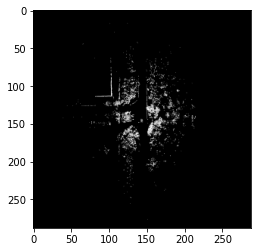

In [4]:
plt.imshow(data[0],cmap='gray')

In [5]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256
train_dataset = tf.data.Dataset.from_tensor_slices(data).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [6]:
input_shape = [288,288,1]

In [7]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(input_shape[0]/4*input_shape[1]/4*BATCH_SIZE, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((int(input_shape[0]/4), int(input_shape[1]/4), BATCH_SIZE)))
    assert model.output_shape == (None, input_shape[0]/4, input_shape[1]/4, BATCH_SIZE)  # None is the batch size

    model.add(layers.Conv2DTranspose(BATCH_SIZE/2, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, input_shape[0]/4, input_shape[1]/4, BATCH_SIZE/2)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(BATCH_SIZE/4, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, input_shape[0]/2, input_shape[1]/2, BATCH_SIZE/4)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(input_shape[2], (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    # print(model.output_shape)
    assert model.output_shape == (None, input_shape[0], input_shape[1], input_shape[2])
    print(model.summary())
    return model

In [8]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1327104)           132710400 
                                                                 
 batch_normalization (BatchN  (None, 1327104)          5308416   
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 1327104)           0         
                                                                 
 reshape (Reshape)           (None, 72, 72, 256)       0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 72, 72, 128)      819200    
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 72, 72, 128)      5

In [9]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(BATCH_SIZE/4, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=input_shape))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(BATCH_SIZE/2, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [10]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[0.00035246]], shape=(1, 1), dtype=float32)


In [11]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [12]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [13]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [14]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [27]:
checkpoint_dir = './training_checkpoints_288288'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [16]:
EPOCHS = 100
noise_dim = 100
num_examples_to_generate = 1

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [17]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))


In [31]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1+38) % 40 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch+64, time.time()-start))
  # Generate after the final epoch
  # display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)


In [30]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  for k in range(num_examples_to_generate):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.imshow(predictions[k],cmap= 'gray')
    plt.savefig('epoch_checkpoints_288288/image_{}_at_epoch_{:04d}.png'.format(k,epoch+64))

    plt.show()

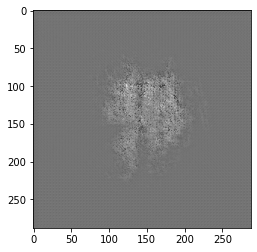

Time for epoch 64 is 570.6193804740906 sec


KeyboardInterrupt: 

In [32]:
%%time
train(train_dataset, EPOCHS)

In [28]:
generated = generator(seed, training=False)
np.array(generated)

array([[[[ 7.9190290e-01],
         [-3.7195614e-01],
         [-6.2431240e-01],
         ...,
         [-8.3293957e-01],
         [-4.1962081e-01],
         [-7.9113418e-01]],

        [[ 5.1835477e-01],
         [ 7.1447802e-01],
         [-2.2752686e-01],
         ...,
         [ 5.1706260e-01],
         [-9.0068024e-01],
         [ 4.6474606e-01]],

        [[ 9.3463105e-01],
         [ 9.6615553e-01],
         [ 9.9519825e-01],
         ...,
         [ 9.9686694e-01],
         [ 9.9305993e-01],
         [-5.7547134e-01]],

        ...,

        [[ 1.1104732e-01],
         [-3.9972428e-02],
         [ 1.9261366e-02],
         ...,
         [ 6.0361616e-02],
         [ 1.2228705e-02],
         [ 8.9900658e-02]],

        [[-2.1303169e-02],
         [-5.2520990e-02],
         [ 2.4327777e-02],
         ...,
         [-3.2157691e-03],
         [-6.9072112e-02],
         [ 5.2874301e-02]],

        [[-2.2217449e-02],
         [-1.1325999e-02],
         [-8.4250562e-02],
         ...,
 

In [ ]:
theta_scale = np.linspace(1.3, 2.2,80)
phi_scale = np.linspace(-np.pi, np.pi,640)

# Original Image, Spherical notation (xyz)

(13284, 3)


C:\Users\youss\AppData\Local\Temp/ipykernel_24640/1210108256.py:21: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


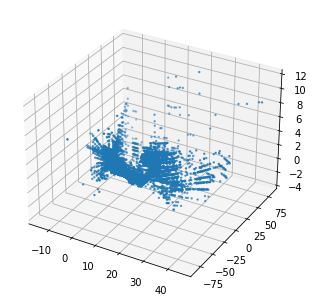

In [62]:
scan_3d = []

current_phi = phi_scale[0]
current_theta = theta_scale[0]
for i in range(1,80):
    for j in range(1,640):
        if not one_scan[i][j] <=0:
            avg_phi = (current_phi+ phi_scale[j])/2
            avg_theta = (current_theta+ theta_scale[i])/2

            radius = one_scan[i][j]
            x = radius * math.cos(avg_phi) * math.sin(avg_theta)
            y = radius * math.sin(avg_phi) * math.sin(avg_theta)
            z = radius * math.cos(avg_theta)
            scan_3d.append(np.array([x,y,z]))
        current_phi = phi_scale[j]
    current_theta = theta_scale[i]
scan_3d = np.array(scan_3d)
print(scan_3d.shape)
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(scan_3d[:,0], scan_3d[:,1], scan_3d[:,2], s=2)
plt.show()

# Original Image, Spherical notation (normalised)
Shows difficulty of visual interpretation once values are normalised

C:\Users\youss\AppData\Local\Temp/ipykernel_3348/3489861625.py:20: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


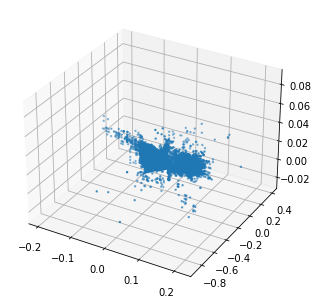

In [34]:
scan_3d = []

current_phi = phi_scale[0]
current_theta = theta_scale[0]
for i in range(1,80):
    for j in range(1,640):
        if not normed_scan[i][j] <=0:
            avg_phi = (current_phi+ phi_scale[j])/2
            avg_theta = (current_theta+ theta_scale[i])/2

            radius = normed_scan[i][j]
            x = radius * math.cos(avg_phi) * math.sin(avg_theta)
            y = radius * math.sin(avg_phi) * math.sin(avg_theta)
            z = radius * math.cos(avg_theta)
            scan_3d.append(np.array([x,y,z]))
        current_phi = phi_scale[j]
    current_theta = theta_scale[i]
scan_3d = np.array(scan_3d)
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(scan_3d[:,0], scan_3d[:,1], scan_3d[:,2], s=2)
plt.show()

# Generated Image, spherical notation using d as GAN input

C:\Users\youss\AppData\Local\Temp/ipykernel_24640/1373362737.py:20: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


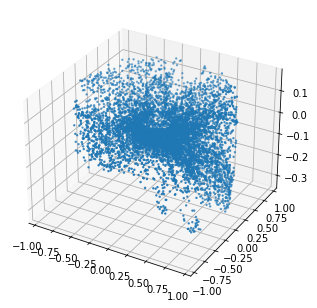

In [66]:
scan_3d = []

current_phi = phi_scale[0]
current_theta = theta_scale[0]
for i in range(1,80):
    for j in range(1,640):
        if generated[0][i][j] >0.2 and generated[0][i][j]<0.95:
            avg_phi = (current_phi+ phi_scale[j])/2
            avg_theta = (current_theta+ theta_scale[i])/2

            radius = generated[0][i][j]
            x = radius * math.cos(avg_phi) * math.sin(avg_theta)
            y = radius * math.sin(avg_phi) * math.sin(avg_theta)
            z = radius * math.cos(avg_theta)
            scan_3d.append(np.array([x,y,z]))
        current_phi = phi_scale[j]
    current_theta = theta_scale[i]
scan_3d = np.array(scan_3d)
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(scan_3d[:,0], scan_3d[:,1], scan_3d[:,2], s=2)
plt.show()

# Original image using Polar notation ( axes correspond to phi and theta, point colour corresponds to d)

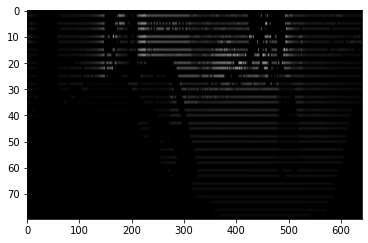

In [35]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.imshow(data[0][:,:,0], cmap='gray')
ax.set_aspect(5)

plt.show()

# Original image using Polar notation ( Normalized)

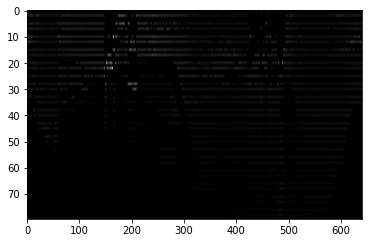

In [35]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.imshow(normed_scan, cmap='gray')
ax.set_aspect(5)

plt.show()

# Generated Image in Polar Notation

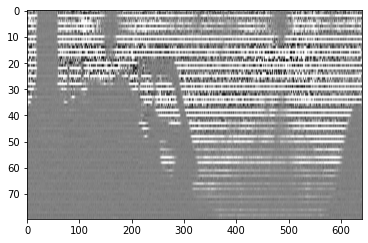

In [37]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.imshow(generated[0], cmap='gray')
ax.set_aspect(5)

plt.show()

# Generated Spherical Image using d and z as GAN input

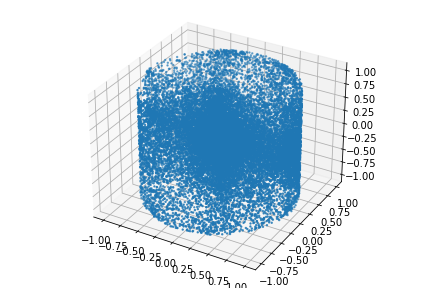

In [1]:
%matplotlib inline
from IPython.display import Image
Image('epoch_checkpoints_2d/image_0_at_epoch_0101.png')

# Cartesian and spherical images using Daniel Bogdoll code

In [ ]:
cloud_2d = np.load('C:/Users/youss/OneDrive/Documents/Education/Thesis/Coding/assets/Test_data/result/000001.npz', allow_pickle=True)['arr_0']
fig = plt.figure()
ax = fig.add_subplot(111)

ax.imshow(cloud_2d)
ax.set_aspect(5)

plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


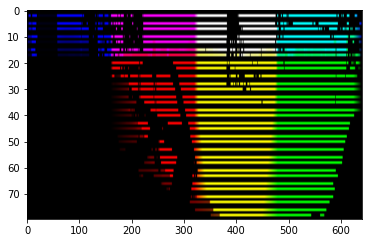

In [15]:
def calc_phi(x,y):
    return math.atan2(y,x)
def calc_theta(x,y,z):
    return math.acos(z/math.sqrt(x**2 + y**2 + z**2))
def calc_d(x,y):
    return math.sqrt(x**2+y**2)
cloud_3d_og = np.genfromtxt(
        'C:/Users/youss/OneDrive/Documents/Education/Thesis/Coding/assets/Test_data/test/000001.csv',
        delimiter=',')[:, :3]
data_og = []
for point in cloud_3d_og:
    phi = calc_phi(point[0],point[1])
    theta = calc_theta(point[0],point[1],point[2])
    d = calc_d(point[0],point[1])
    data_og.append(np.array([theta,phi,d]))
spherical_coords = np.array(data_og)

new_2d_scan = np.zeros((80,640,3))
current_theta = theta_scale[0]
current_phi = phi_scale[0]
for i in range(1,640):
    for j in range(1,80):
        idx = np.where((spherical_coords[:,0] > current_theta) & (spherical_coords[:,0] < theta_scale[j]) & (spherical_coords[:,1] > current_phi) & (spherical_coords[:,1] <phi_scale[i]))
        if idx[0].size != 0:
            x = np.average(cloud_3d_og[idx[0],0])
            y = np.average(cloud_3d_og[idx[0],1])
            z = np.average(cloud_3d_og[idx[0],2])
            new_2d_scan[j-1][i-1] = np.array([x,y,z])
        else:
            new_2d_scan[j-1][i-1] = np.array([0,0,0])
        current_theta = theta_scale[j]
    current_phi = phi_scale[i]

fig = plt.figure()
ax = fig.add_subplot(111)

ax.imshow(new_2d_scan)
ax.set_aspect(5)

plt.show()

Original 3D representation

C:\Users\youss\AppData\Local\Temp\ipykernel_63908\4033081951.py:2: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


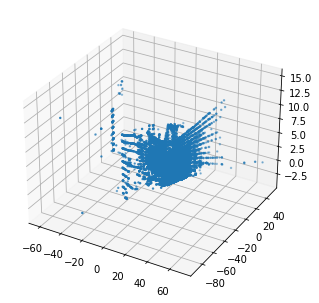

In [19]:
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(cloud_3d_og[:,0], cloud_3d_og[:,1], cloud_3d_og[:,2], s=2)
plt.savefig('OG_3d_scan.png')
plt.show()

Bogdoll pre-processing 3D reconstruction

C:\Users\youss\AppData\Local\Temp\ipykernel_63908\3991395953.py:3: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


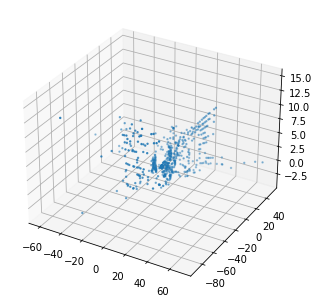

In [22]:
bog_ed = cloud_2d.reshape((80*640,3))
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(bog_ed[:,0], bog_ed[:,1], bog_ed[:,2], s=2)
plt.show()

Our cartesian pre-processing 3D reconstruction

C:\Users\youss\AppData\Local\Temp\ipykernel_63908\2900966357.py:3: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


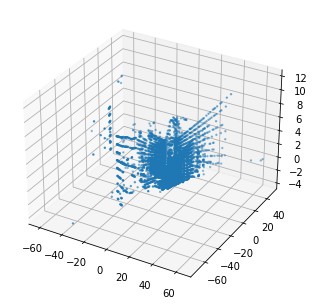

In [18]:
scan_3d = new_2d_scan.reshape((80*640,3))
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(scan_3d[:,0], scan_3d[:,1], scan_3d[:,2], s=2)
plt.show()